<b>Задача</b><br>
Требуется на основании имеющихся данных о клиентах банка, построить модель, используя обучающий dataset, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового dataset.<br>
Целевая переменная<br>
Credit default - факт невыполнения кредитных обязательств<br>
Метрика качества
F1-score (sklearn.metrics.f1_score)
Требования к решению<br>
Целевая метрика F1>0.5 (Метрика оценивается по качеству для главного класса: 1-просрочка по кредиту)

<b>Секция импортов</b>

In [276]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

#!pip install imblearn
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report




<b>Чтение данных и предварительный анализ</b>

In [296]:
# 1
# Reading:------------------------------------------------------------
train_project_path = "course_project_train.csv"
test_project_path = "course_project_test.csv"

df = pd.read_csv(train_project_path)
df_test = pd.read_csv(test_project_path)

# Printing respective labels:-----------------------------------------
print ("Train columns:\n{}\n\n Test columns:\n{}\n\n".format(df.columns,df_test.columns))



Train columns:
Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

 Test columns:
Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')




In [297]:
# 2
# Selecting target:-------------------------------------------------
TARGET = "Credit Default";

#ATTENTION: The test data set has no TARGET.

In [298]:
# 3
# Printing basic content info:---------------------------------------
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [299]:
# Failed feature:
df = df.drop(columns="Months since last delinquent");

# 4
# Counting objects per class. According the main target column:--------
df[TARGET].value_counts()



0    5387
1    2113
Name: Credit Default, dtype: int64

In [300]:
# 5
# Counting NAN or NULLs:-----------------------------------------------
na_columns = [];
for column in df.columns:
    na_sum = df[column].isna().sum();
    if na_sum>0:
        na_columns.append(column);
print("Nan columns: {}".format(na_columns));
df.isna().sum()

Nan columns: ['Annual Income', 'Years in current job', 'Bankruptcies', 'Credit Score']


Home Ownership                  0
Annual Income                1557
Years in current job          371
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Bankruptcies                   14
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                 1557
Credit Default                  0
dtype: int64

In [301]:
# 6
# Simple counting NULLs:-----------------------------------------------
df.isnull().sum()

Home Ownership                  0
Annual Income                1557
Years in current job          371
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Bankruptcies                   14
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                 1557
Credit Default                  0
dtype: int64

In [302]:
# 7
# Selecting NON-numerical properties:-----------------------------------
object_type_columns = [];
for column in df.columns:
    column_info = df[column].value_counts();
    type_info = df[column].dtype;
    print("Column: {} type={}\n\n {}\n\n".format(str(column),type_info,str(column_info)));
    if type_info=='object':
        object_type_columns.append(column);
object_type_columns

Column: Home Ownership type=object

 Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


Column: Annual Income type=float64

 1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64


Column: Years in current job type=object

 10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


Column: Tax Liens type=float64

 0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64


Column: Number of Open Accounts type=float64

 9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    46

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [303]:
# 8
# The basic statistical description:----------------------------------------
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


<b>По результатам наблюдений можно заключить:</b>
1. На чтении у тестовых данных не найдено правильных ответов, поэтому их в расчет не берем. Нужно будет разбивать train исходные данные на две части
2. Всего 17 колонок вместе с target. Имеются 4 категориальных признака. Имеются пропуски по разным колонкам
3. Признаки имеют разный max/min. Если смотреть на средние значения то порядки начиная от 10 ков , 1000 и есть 1000000
4. Из секции 4 видно, что данные относительно сбалансированы: 5387 против 2113


<b>План работ:</b><br>
1. Убираем категориальные признаки
2. Нули заменяем модами. О заменах делаем пометки в отдельной колонке
3. Масштабируем dataset
4. Балансировка по классам (опциональна)
5. Возможно, целесообразно сжать данные на основе АГК

In [304]:
# Marking NULLS:-----------------------------------------------
new_df = df.copy();
for na_column in na_columns:
    na_cnt = new_df[na_column].isna().sum();
    print ("Null counter = {} for column={} type={}".format(na_cnt,na_column,new_df[na_column].dtype));
    na_column_indicator = na_column+'_na';
    new_df[na_column_indicator] = 0;
    new_df.loc[new_df[na_column].isna(), na_column_indicator] = 1;

# Removing NULLS:----------------------------------------------
for na_column in na_columns:
    na_median = new_df[na_column].value_counts().idxmax();#median(numeric_only=False);
    print ("Replacing for {} by median {}".format(na_column,na_median));
    new_df[na_column] = new_df[na_column].fillna(na_median);

new_df.isna().sum()


Null counter = 1557 for column=Annual Income type=float64
Null counter = 371 for column=Years in current job type=object
Null counter = 14 for column=Bankruptcies type=float64
Null counter = 1557 for column=Credit Score type=float64
Replacing for Annual Income by median 1338113.0
Replacing for Years in current job by median 10+ years
Replacing for Bankruptcies by median 0.0
Replacing for Credit Score by median 740.0


Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
Annual Income_na             0
Years in current job_na      0
Bankruptcies_na              0
Credit Score_na              0
dtype: int64

In [305]:
# Adding object markers:-----------------------------------
for object_type_column in object_type_columns:
    dummies = pd.get_dummies(new_df[object_type_column],prefix=column);
    new_df=pd.concat([new_df,dummies],axis=1)
    print ("Adding dummies {} for {}\n".format(dummies.columns,object_type_column))

# Removing object columns:---------------------------------
for object_type_column in object_type_columns:
    new_df = new_df.drop(columns=object_type_column);
    print ("Dropping object column: {}".format(object_type_column));

new_df.info();

Adding dummies Index(['Credit Default_Have Mortgage', 'Credit Default_Home Mortgage',
       'Credit Default_Own Home', 'Credit Default_Rent'],
      dtype='object') for Home Ownership

Adding dummies Index(['Credit Default_1 year', 'Credit Default_10+ years',
       'Credit Default_2 years', 'Credit Default_3 years',
       'Credit Default_4 years', 'Credit Default_5 years',
       'Credit Default_6 years', 'Credit Default_7 years',
       'Credit Default_8 years', 'Credit Default_9 years',
       'Credit Default_< 1 year'],
      dtype='object') for Years in current job

Adding dummies Index(['Credit Default_business loan', 'Credit Default_buy a car',
       'Credit Default_buy house', 'Credit Default_debt consolidation',
       'Credit Default_educational expenses',
       'Credit Default_home improvements', 'Credit Default_major purchase',
       'Credit Default_medical bills', 'Credit Default_moving',
       'Credit Default_other', 'Credit Default_renewable energy',
       'Credit

In [306]:
# Making X ,Y for training and analysis:-------------------------------
Y = pd.DataFrame(data=new_df,columns=[TARGET])
cut_df = new_df.drop(columns=TARGET);
X = pd.DataFrame(data=cut_df,columns=cut_df.columns);
#X.info();
#Y.value_counts()



In [307]:
# Splitting for test and train sets:-----------------------------------
# train---test----train-----test-----
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.5,shuffle=True,random_state=1)
print("X train shape={}".format(x_train.shape));
print("X test shape={}".format(x_test.shape));
print("Y train shape={}".format(y_train.shape));
print("Y test shape={}".format(y_test.shape));
#y_train.value_counts()

X train shape=(3750, 47)
X test shape=(3750, 47)
Y train shape=(3750, 1)
Y test shape=(3750, 1)


In [308]:
# The basic function for executing scalers:----------------------------
def execute_scaling (x_train, scaler, x_test, make_data_frame):
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if make_data_frame:
        x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
        x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns);
    
    return (x_train_scaled, x_test_scaled)


# Scaling:-------------------------------------------------------------
scaler = RobustScaler()
x_train,x_test = execute_scaling(x_train=x_train,scaler=scaler,
                                x_test=x_test,make_data_frame=False);

In [309]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(n_estimators=100,max_depth=20, random_state=0)
clf.fit(x_train,y_train[TARGET])

y_pred = clf.predict(x_test);
class_report = classification_report(y_test,y_pred);
print ("Classification report: \n{}".format(class_report));

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.

C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alex\DevProgs\Anaconda\lib\site-packages\sklearn\utils\parallel.

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      2704
           1       0.45      0.64      0.53      1046

    accuracy                           0.68      3750
   macro avg       0.64      0.67      0.64      3750
weighted avg       0.72      0.68      0.69      3750



In [310]:
#
# Sampling:------------------------------------------------------------
#sampler = TomekLinks();
#x_train,y_train = sampler.fit_resample(x_train,y_train);
#y_train.value_counts()

#renn = RepeatedEditedNearestNeighbours()
#x_train, y_train = renn.fit_resample(x_train, y_train)
#y_train.value_counts()

renn = EditedNearestNeighbours()
x_train, y_train = renn.fit_resample(x_train, y_train)
y_train.value_counts()

#rus = RandomUnderSampler(random_state=0)
#x_train, y_train = rus.fit_resample(x_train, y_train)
#y_train.value_counts()

#allknn = AllKNN()
#x_train, y_train = allknn.fit_resample(x_train, y_train)
#y_train.value_counts()

#smt = SMOTE()
#x_train, y_train = smt.fit_resample(x_train, y_train)
#y_train.value_counts()


Credit Default
0                 1431
1                 1067
dtype: int64

PCA explained variance [5.97460022e-01 2.75164484e-01 1.26963070e-01 1.44990975e-04
 5.81706862e-05 3.42173389e-05 2.96836004e-05 1.94254968e-05
 1.69728745e-05 1.58555541e-05 1.54132752e-05 1.20836247e-05
 1.02565882e-05 9.55313313e-06 5.41934623e-06 4.21999697e-06
 3.95962276e-06 3.67425846e-06 3.38818510e-06 3.29412192e-06
 3.15696713e-06 3.04162131e-06 2.95598876e-06 2.87735202e-06
 2.10316192e-06 1.81715250e-06 1.46099051e-06 1.33412307e-06
 7.89394423e-07 5.45317782e-07 4.87940642e-07 3.33791111e-07
 2.48640444e-07 2.13657121e-07 1.41764270e-07 8.69928205e-08
 7.43278546e-08 7.03633277e-08 5.80948736e-08 2.80825146e-08
 1.96849558e-08 4.81609721e-33 4.81609721e-33 4.81609721e-33
 4.81609721e-33 4.81609721e-33 4.81609721e-33]
Components number=24 percentage=0.99999


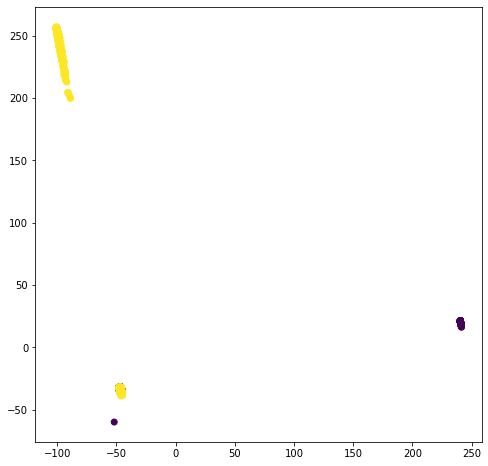

In [311]:
# Applying PCA:-------------------------------------------------------
pca_instance = PCA();
pca_instance.fit_transform(x_train);

print("PCA explained variance {}".format(pca_instance.explained_variance_ratio_))
xtr=0.0
suitable_component_num=0
percentage=0.99999;
for num,var_ratio in enumerate(pca_instance.explained_variance_ratio_):
    xtr=xtr+var_ratio
    if xtr>=percentage:
        suitable_component_num = num+1;
        break;
print ("Components number={} percentage={}".format(suitable_component_num,percentage));


# Zipping the dataset by the optimal component number:----------------
pca_instance = PCA (n_components=suitable_component_num);
x_train_pca=pca_instance.fit_transform(x_train);
x_test_pca = pca_instance.transform(x_test)


# Researching:--------------------------------------------------------
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8,8

x=x_train_pca[0:x_train_pca.shape[0],0:1];
y=x_train_pca[0:x_train_pca.shape[0],1:2];
plt.scatter(x,y,c=y_train[TARGET]);
plt.show();


In [312]:

# Searching the best tree parameters:------------------------------------------------------------
parameters = [{'n_estimators':np.arange(20,120,10),'max_features':np.arange(1,15,3),'max_depth':np.arange(2,15,2)}]

# n_estimators - is the number of trees 
# max_features - Max parameters per tree
# max_depth - max depth of the each tree
# grid search with cross validation. cv = 5. The first fourth groups (FOLDS)
# of the train set is used for FIT the last is used for vaidation
gs = GridSearchCV(estimator=RandomForestClassifier(random_state=100),param_grid=parameters,scoring='f1_weighted')#,cv=3,verbose=1)
gs.fit(x_train,y_train[TARGET])

print ("Best params: {}".format(gs.best_params_));


Best params: {'max_depth': 14, 'max_features': 10, 'n_estimators': 100}


In [313]:

# Making predictions by the best tree:------------------------------------------------------------
best = gs.best_params_;
random_forest = RandomForestClassifier(n_estimators=best['n_estimators'],max_features=best['max_features'],max_depth=best['max_depth'],random_state=100);
#random_forest = RandomForestClassifier(n_estimators=100,max_features=5,max_depth=15,random_state=100);

random_forest.fit(x_train,y_train[TARGET]);
y_pred = random_forest.predict(x_test);
class_report = classification_report(y_test,y_pred);
print ("Classification report: \n{}".format(class_report));


Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.65      0.73      2704
           1       0.43      0.67      0.52      1046

    accuracy                           0.66      3750
   macro avg       0.63      0.66      0.63      3750
weighted avg       0.72      0.66      0.67      3750



In [314]:
# Making predictions by the LogisticRegression:---------------------------------------------------
lin_reg = LogisticRegression(max_iter=1000);
lin_reg.fit(x_train,y_train[TARGET]);
y_pred = lin_reg.predict(x_test);

class_report = classification_report(y_test,y_pred);
print ("Classification report: \n{}".format(class_report));

Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.65      0.74      2704
           1       0.43      0.69      0.53      1046

    accuracy                           0.66      3750
   macro avg       0.64      0.67      0.63      3750
weighted avg       0.73      0.66      0.68      3750

